In [1]:
from typing import List
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
"""
Definim una classe per a oscil·ladors amb les caracteristiques que té un oscil·lador (massa, constant elàstica...)
"""
class Oscilador:

    def __init__(self, massa: float, constant: float, posInicial: float, momentInicial: float) -> None:

        self.massa: float = massa
        self.constant: float = constant
        self.pos: float = posInicial
        self.moment: float = momentInicial

        self.energia: float = (self.moment** 2) / (2 * self.massa) + 1 / 2 * self.constant * (self.pos ** 2)


    """
    Funció per a calcular l'evolució newtoniana de l'oscil·lador
    El moment de l'oscil·lador varia en funció de la posició (llei de Hooke) o bé ve determinat per condicions externes
    (prenem com a valor llavors el moment estricte)
    La posició de l'oscil·lador varia en funció del moment
    Calculem també la nova energia de l'oscil·lador
    """
    def iterar(self, deltaT: float, momentEstricte: float | None = None) -> None:
        self.moment = self.moment + (-self.constant * self.pos) * deltaT if momentEstricte is None else momentEstricte
        self.pos = self.pos + self.moment / self.massa * deltaT
       
        self.energia = (self.moment** 2) / (2 * self.massa) + 1 / 2 * self.constant * (self.pos ** 2)

    """ 
    Funció que retorna el valor del hamiltonià de l'oscilador (amb el valor propi del moment o amb un altre valor del moment)
    """
    def hamiltonia(self, momentAlternatiu: float | None = None) -> float:
        if momentAlternatiu is None: momentAlternatiu = self.moment
        
        return (momentAlternatiu ** 2) / 2 - self.constant/2 * (self.pos ** 2)

In [3]:

"""
Funció que simula el sistema a una determinada temperatura, durant un temps concret i amb una delta P concreta
Retorna la incertesa de l'energia quan el sistema està en equilibri tèrmic (definit com a partir de 100 segons)
"""
def simular(temperatura: float, temps: float, deltaP: float, graficar: str | None = None) -> float | None:


    dt:float = 0.005
    N_ITERACIONS: int = int(temps / dt)

    BETA_BANY: float = 1 / temperatura

    oscilador: Oscilador = Oscilador(1,1,0,1)


    posicions: List[float] = []
    energies: List[float] = []
    energies2: List[float] = []


    t=0
    for _ in range(N_ITERACIONS): #Loop 
        t += dt

        randomN = random.random()

        """
        Computem l'increment de moment degut al bany tèrmic (50 % positiu 50% negatiu) i el moment resultant d'aquest increment
        (hem de veure si acceptem aquest nou moment o el descartem)
        """
        increment:float = deltaP if randomN < 0.5 else -deltaP

        momentBany = oscilador.moment + increment

        """
        Computem els dos factors de boltzmann que sorgeixen dels hamiltonians de les dues situacions possibles
        (una es la situació amb el moment modificat i l'altra no)
        """ 
        factorBany = np.exp(-BETA_BANY * oscilador.hamiltonia(momentBany))
        factorNormal = np.exp(-BETA_BANY * oscilador.hamiltonia())
        
        probabilitat = factorBany/factorNormal

        randomN = random.random()
        if oscilador.hamiltonia(momentBany) < oscilador.hamiltonia() or randomN < probabilitat:
            """
            Regla de metropolis: 
            Acceptarem com a nou moment el moment modificat pel bany si el hamiltonià d'aquest és menor que el hamiltonià
            sense modificacions o (en cas de no donar-se això), si probabilisticament es dona el cas.
            """
            oscilador.moment = momentBany
        
        #ITERAREM SOBRE L'OSCILADOR PER FER EVOLUCIONAR LA SEVA POSICIÓ SEGONS NEWTON
        oscilador.iterar(dt)

        """ 
        Guardarem totes les posicions de l'oscilador per a graficar-ho i les energies de l'oscilador per al calcul de l'incertesa
        """
        if graficar != None: posicions += [oscilador.pos]

        if t > 100:
            energies += [oscilador.energia]
            energies2 += [oscilador.energia ** 2]

    #CALCULEM L'INCERTESA
    incertesa2 = None if temps < 100 else np.mean(energies2) - (np.mean(energies) ** 2)

    if graficar == "posicio_temps":
        plt.clf()
        plt.plot([i * dt for i in range(N_ITERACIONS)], posicions, "r.")
        plt.grid()

    elif graficar == "histograma":
        plt.clf()
        plt.hist(posicions, weights=[1/N_ITERACIONS] * N_ITERACIONS, bins=50, label='Números generats a 6, vàlids')
        plt.xlabel("Posicions", fontsize=19)
        plt.ylabel("Probabilitat", fontsize=19)
        #plt.title("Distribució de posicions de l'oscil·lador harmònic",fontsize=18)

    return None if temps < 100 else np.sqrt(incertesa2)


SIMULACIONS PER A L'APARTAT 1 I 2. ÚNICAMENT CAL CORRER LA FUNCIÓ SIMULAR AMB ELS PARÀMETRES QUE DESITJEM

In [5]:


DELTA_P = 0.002

#simular(3e3, 20000, DELTA_P, graficar="histograma")


CODI PER A L'APARTAT 3. AQUÍ REALITZAREM DIVERSES SIMULACIONS I GRAFICAREM ELS VALORS DE LES INCERTESES OBTINGUTS

In [8]:
"""
Aixo es pel 3c Calculem les incerteses d'una serie de temperatures
Mirem la corba de regressió i veiem que s'ajusta bastant bé a una recta de regressió

El valor del pendent (coeffs[0]) està "a prop" de 1 que és el que hauria de ser perquè hem considerat
que la constant de boltzmann és 1
"""
T = 1e-3
incerteses = []
temps = []
for i in range(40):
    
    incerteses += [simular(T, 1500, DELTA_P, None) ** 2]
    temps += [T]
    T += 1e-4

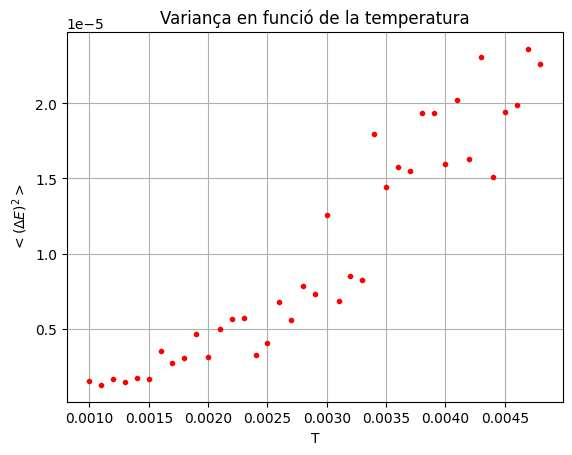

In [12]:
plt.plot(temps[:-1], incerteses[:-1], "r.")
#plt.plot(temps, [coeffs[1] + coeffs[0] * temp for temp in temps], "b-")
plt.title("Variança en funció de la temperatura")
plt.xlabel("T")
plt.ylabel(r'$<\left ( \Delta E \right ) ^{2}>$')
plt.grid()

In [14]:
import scipy


In [19]:
xs = [t ** 2 for t in temps]
ys = incerteses
results = scipy.stats.linregress(xs, ys)
print(results)

LinregressResult(slope=1.0514299023276412, intercept=-1.2903638984557407e-07, rvalue=0.9517371149473364, pvalue=1.4284906062083432e-20, stderr=0.055741641830044986, intercept_stderr=6.536989595052392e-07)


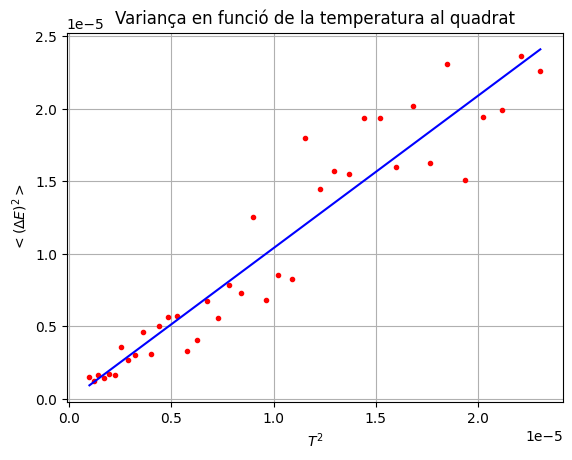

In [20]:
plt.plot(xs, ys, "r.")
plt.plot(xs, [results.intercept + results.slope * temp for temp in xs], "b-")
plt.title("Variança en funció de la temperatura al quadrat")
plt.xlabel(r'$T^{2}$')
plt.ylabel(r'$<\left ( \Delta E \right ) ^{2}>$')
plt.grid()